In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt

import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
import numpy as np

In [2]:
import torch.utils.data as data
from PIL import Image
import os

#1. Loading data

## Download dataset

- MNIST

In [3]:
import torchvision.datasets as datasets

# Download MNIST dataset
mnist_train_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
mnist_test_dataset  = datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 9912422/9912422 [00:00<00:00, 322125029.98it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 136414069.62it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 173213399.37it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 4710813.25it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



- MNIST-M

In [4]:
!wget https://github.com/mashaan14/MNIST-M/raw/main/MNIST-M.zip


--2023-06-22 09:33:14--  https://github.com/mashaan14/MNIST-M/raw/main/MNIST-M.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/mashaan14/MNIST-M/main/MNIST-M.zip [following]
--2023-06-22 09:33:14--  https://media.githubusercontent.com/media/mashaan14/MNIST-M/main/MNIST-M.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146914983 (140M) [application/zip]
Saving to: ‘MNIST-M.zip’

MNIST-M.zip         100%[===================>] 140.11M   404MB/s    in 0.3s    

2023-06-22 09:33:24 (404 MB/s) - ‘MNIST-M.zip’ saved [146914983/146914983]



In [5]:
! yes | unzip -q MNIST-M.zip -d dataset/


## Create Data Loader

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
from torch.utils.data import Dataset, DataLoader

class MNISTM_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []
        self.labels = []

        for class_dir in os.listdir(self.root_dir):
            class_path = os.path.join(self.root_dir, class_dir)

            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                self.file_list.append(image_path)
                self.labels.append(int(class_dir))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        image_path = self.file_list[index]
        label = self.labels[index]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
target_image_root = os.path.join('dataset', 'MNIST-M')
source_image_root = os.path.join('dataset', 'MNIST')

model_root = os.path.join('..', 'models')
cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 10

manual_seed = random.randint(1, 10000)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [20]:
img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB with 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

# SOURCE DATASET
source_dataset = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

source_dataloader = DataLoader(
    dataset=source_dataset,
    batch_size=batch_size,
    shuffle=True)



In [21]:
mnist_train_path = os.path.join(target_image_root, 'training')

target_dataset = MNISTM_Dataset(
    mnist_train_path,
    transform=img_transform_target)


target_dataloader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True)


In [26]:
print(len(target_dataset))
print(len(source_dataset))

59000
60000


## Visualize some inputs

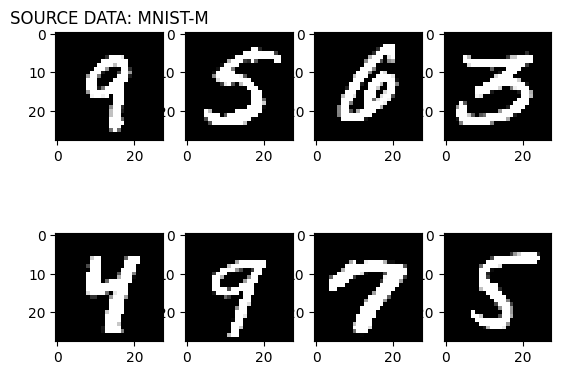

In [25]:
samples, labels = next(iter(source_dataloader))
samples = np.transpose(samples, (0, 2, 3, 1))
#rescale iamges

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(samples[i])
    if i==0:
        plt.title("SOURCE DATA: MNIST-M")


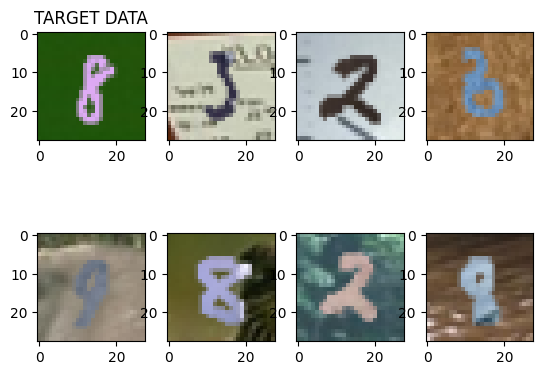

In [36]:
samples, labels = next(iter(target_dataloader))
samples = np.transpose(samples, (0, 2, 3, 1))
#rescale iamges
samples = (samples * 0.5) + 0.5

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(samples[i])
    if i==0:
        plt.title("TARGET DATA")


In [29]:
print(len(source_dataloader))
print(len(target_dataloader))

469
461


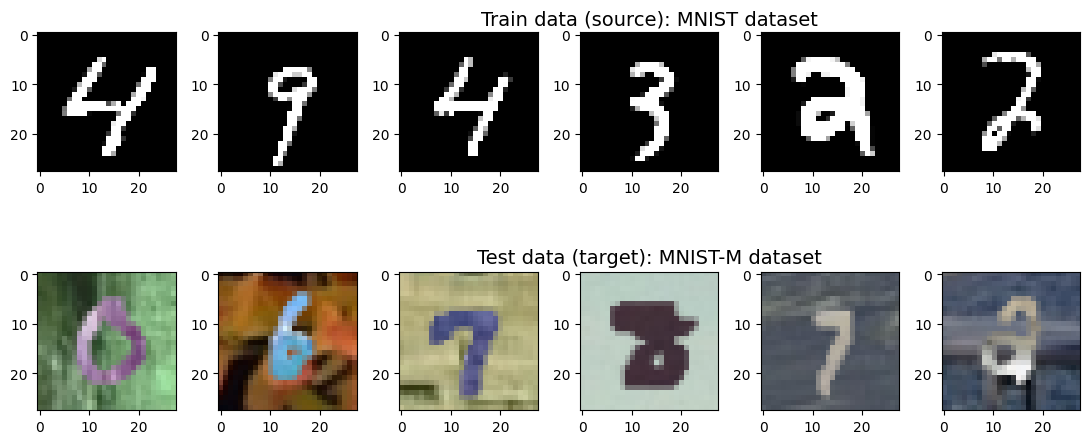

In [38]:
samples, labels = next(iter(source_dataloader))
samples = np.transpose(samples, (0, 2, 3, 1))

fig, axs = plt.subplots(2, 6, figsize=(11, 5))  # Adjust figsize as desired

for i in range(6):
    axs[0, i].imshow(samples[i], cmap='gray')
    if i == 3:
        axs[0, i].set_title("Train data (source): MNIST dataset", fontsize=14)


# Second Subplot: MNISTM
samples, labels = next(iter(target_dataloader))
samples = np.transpose(samples, (0, 2, 3, 1))
samples = (samples * 0.5) + 0.5

for i in range(6):
    axs[1, i].imshow(samples[i], cmap='gray')
    if i == 3:
        axs[1, i].set_title("Test data (target): MNIST-M dataset", fontsize=14)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


# Model

## Domain Classifier

In [39]:
class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout2d(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, input_img):
        feature = self.feature_extractor(input_img)
        feature = feature.view(feature.size(0), -1)  # Flatten the feature tensor
        domain_output = self.classifier(feature)
        # domain_prob = torch.softmax(domain_output, dim=1)
        return domain_output



Prepare data for domain classsifier: Merge source and target in to one dataloader, label of dataset is the domain of the data (if domain is target then label is 1, else then  0)


## Label Classifier

In [63]:
class LabelClassifier(nn.Module):
    def __init__(self):
        super(LabelClassifier, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32 * 5 * 5, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )

    def forward(self, input_img):
        feature = self.feature_extractor(input_img)
        feature = feature.view(feature.size(0), -1)  # Flatten the feature tensor
        output = self.classifier(feature)
        return output



## Loss Function

In [40]:
class ReweightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(ReweightedCrossEntropyLoss, self).__init__()
        self.loss_function = nn.CrossEntropyLoss(reduction='none')

    def forward(self, input, label, domain_output, threshold, max_value):
        # Calculate the standard CrossEntropyLoss
        loss = self.loss_function(input, label)

        source_prob = domain_output[:, 1]
        target_prob = domain_output[:, 0]
        weights = torch.sqrt(target_prob / (source_prob + 1e-8))  # Add a small epsilon to avoid division by zero

        weights = torch.where(weights < threshold, torch.tensor(threshold), weights)
        weights = torch.where(weights > max_value, torch.tensor(max_value), weights)

        weighted_loss = (weights * loss).mean()

        return weighted_loss


Visualize merged dataset (source + target dataset)

#  Training

## Train Domain Classifier

- We create the TargetSourceDatset to train the Domain Classifier

In [41]:
from torch.utils.data import Dataset, DataLoader

class TargetSourceDataset(Dataset):

    def __init__(self, target_dataset, source_dataset):
        self.target_dataset = target_dataset
        self.source_dataset = source_dataset

    def __len__(self):
        return len(self.target_dataset) + len(self.source_dataset)

    def __getitem__(self, index):
        if index < len(self.target_dataset):
            image, _ = self.target_dataset[index]
            domain_label = 0  # Target domain label
        else:
            source_index = index - len(self.target_dataset)
            image, _ = self.source_dataset[source_index]
            domain_label = 1  # Source domain label

        return image, domain_label

# Create the combined dataset
target_source_dataset = TargetSourceDataset(target_dataloader.dataset, source_dataloader.dataset)

target_source_dataloader = DataLoader(target_source_dataset, batch_size=batch_size, shuffle=True)


- Visualize some images for sanity check

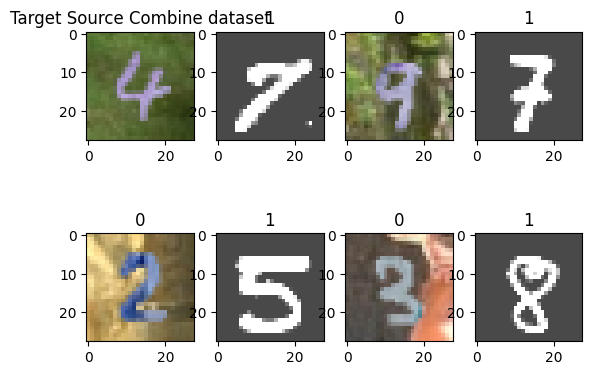

In [42]:
samples, labels = next(iter(target_source_dataloader))
samples = np.transpose(samples, (0, 2, 3, 1))
#rescale iamges
samples = (samples * 0.5) + 0.5

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(samples[i])
    plt.title(labels[i].item())
    if i==0:
        plt.title("Target Source Combine dataset")


- Train the `Domain Classifier`:

In [43]:
lr = 1e-4
batch_size = 128
image_size = 28
n_epoch = 2

domain_classifier = DomainClassifier().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(domain_classifier.parameters(), lr=lr)


LOSS_DOMAIN = []
ACC_DOMAIN = []

for epoch in range(n_epoch):
    correct = 0
    total_samples = 0

    len_target_source_dataloader = len(target_source_dataloader)
    for i, (img, label) in enumerate(target_source_dataloader):
        batch_size = len(img)
        input_img = img.to(device)

        label_output = domain_classifier(input_img)
        label_pred = torch.argmax(label_output, dim=1)

        label = label.to(device)

        correct += (label_pred == label).sum().item()
        total_samples += len(label)

        label_acc = 100.0 * correct / total_samples
        _loss = loss(label_output, label)

        ACC_DOMAIN.append(label_acc)
        LOSS_DOMAIN.append(_loss.item())

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        if (i % 100) == 0 and i!= 0:
            print(f'epoch: {epoch+1}, [iter: {i:03d} / all {len_target_source_dataloader}], '
                    f'loss_label: {_loss.item():.4f}, '
                    f'| label acc: {label_acc:.4f}')



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1, [iter: 100 / all 930], loss_label: 0.3703, | label acc: 97.5093
epoch: 1, [iter: 200 / all 930], loss_label: 0.3401, | label acc: 98.7290
epoch: 1, [iter: 300 / all 930], loss_label: 0.3281, | label acc: 99.1435
epoch: 1, [iter: 400 / all 930], loss_label: 0.3237, | label acc: 99.3571
epoch: 1, [iter: 500 / all 930], loss_label: 0.3202, | label acc: 99.4838
epoch: 1, [iter: 600 / all 930], loss_label: 0.3194, | label acc: 99.5671
epoch: 1, [iter: 700 / all 930], loss_label: 0.3169, | label acc: 99.6289
epoch: 1, [iter: 800 / all 930], loss_label: 0.3168, | label acc: 99.6752
epoch: 1, [iter: 900 / all 930], loss_label: 0.3164, | label acc: 99.7104
epoch: 2, [iter: 100 / all 930], loss_label: 0.3158, | label acc: 99.9923
epoch: 2, [iter: 200 / all 930], loss_label: 0.3154, | label acc: 99.9961
epoch: 2, [iter: 300 / all 930], loss_label: 0.3152, | label acc: 99.9948
epoch: 2, [iter: 400 / all 930], loss_label: 0.3145, | label acc: 99.9961
epoch: 2, [iter: 500 / all 930], loss_

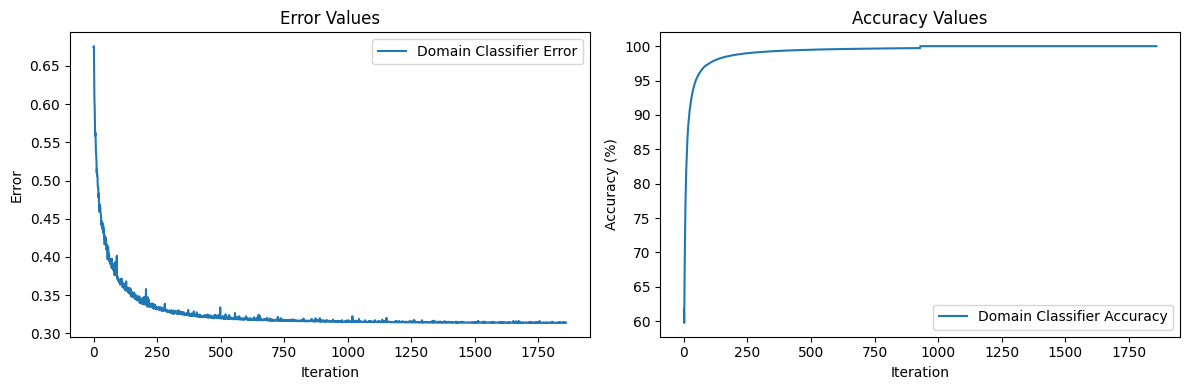

In [44]:
import matplotlib.pyplot as plt


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plotting error values
axes[0].plot(LOSS_DOMAIN, label='Domain Classifier Error')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Error')
axes[0].set_title('Error Values')
axes[0].legend()

# Plotting accuracy values
axes[1].plot(ACC_DOMAIN, label='Domain Classifier Accuracy')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Values')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


`CombinedDataset`: placedholder for outout of the domain classifier which would include source images, label of source image, domain label (1 for source and 0 for target)

In [45]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# Define a custom dataset for the combined data
class CombinedDataset(Dataset):
    def __init__(self, images, labels, domain_outputs):
        self.images = images
        self.labels = labels
        self.domain_outputs = domain_outputs

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        domain_output = self.domain_outputs[index]
        return image, label, domain_output

    def __len__(self):
        return len(self.images)


-  Run the Domain Classifier on Source Dataset:
We then apply model on the `source_dataloader` and then save result into the `CombinedDataset` that we have create

In [46]:
# Calculate overall accuracy
total_correct = 0
total_samples = 0

domain_classifier.eval()  # Set the model to evaluation mode

domain_outputs = []
source_images_list = []
source_labels_list = []

with torch.no_grad():
    for images, source_labels in source_dataloader:
        input_images = images.to(device)
        labels = torch.ones(images.size(0), dtype=torch.long).to(device)

        domain_output = domain_classifier(input_images)
        _, domain_pred = torch.max(domain_output, 1)

        total_correct += (domain_pred == labels).sum().item()
        total_samples += len(labels)

        # print(100.0 * correct/total)

        domain_outputs.append(domain_output)
        source_images_list.append(input_images)
        source_labels_list.append(source_labels)

# Concatenate the domain outputs, images, and labels
combined_domain_output = torch.cat(domain_outputs, dim=0)
combined_source_images = torch.cat(source_images_list, dim=0)
combined_source_labels = torch.cat(source_labels_list, dim=0)

combined_dataset = CombinedDataset(combined_source_images, combined_source_labels, combined_domain_output)

accuracy = 100.0 * total_correct / total_samples
print(f"Accuracy of domain classifier: {accuracy:.4f}%")

batch_size = 128



combined_dataloader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True
)


Accuracy of domain classifier: 100.0000%


In [47]:
print(combined_domain_output.shape)

torch.Size([60000, 2])


# Analysis and Loss Function

We compute  ```re-weight score = p_target / (1- p_target)``` Then, we plot the images with highest and lowest re-weight factor **bold text**

In [48]:
def plot_top_images(images, domain_outputs, top_k=10, axis = 0):
    num_images = len(images)
    num_elements = domain_outputs.shape[0]
    if num_elements < top_k:
        top_k = num_elements

    highest_values, indices = torch.topk(domain_outputs[:, axis], k=top_k, dim=0)
    indices = indices.cpu()  # Move indices to CPU

    num_cols = (top_k + 1) // 2  # Calculate the number of columns

    fig, axs = plt.subplots(nrows=2, ncols=num_cols, figsize=(2 * num_cols, 4))
    fig.subplots_adjust(hspace=0.5)

    for i, (idx, values) in enumerate(zip(indices, highest_values)):
        image = images[idx]
        image = image.cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = image * 0.5 + 0.5  # Convert image tensor to numpy array

        row = i % 2  # Determine the row index
        col = i // 2  # Determine the column index

        axs[row, col].imshow(image)
        if torch.cuda.is_available():  # Check if GPU is available
            if axis == 0:
                w = values.cpu().tolist()
                axs[row, col].set_title(f'{w/(1-w):.2f}')# w/(1-w)
            else:
                w = values.cpu().tolist()
                axs[row, col].set_title(f'{(1-w)/w :.2f}')
        else:
            # print("Using cpu")
            if axis == 0:
                w = values
                axs[row, col].set_title(f'Weight Values: {w/(1-w) :.5f}')
            else:
                w = values
                axs[row, col].set_title(f'Weight Values: {(1-w)/w:.5f}')
        axs[row, col].axis('off')
    if axis == 0:
        plt.suptitle("Top HIGHEST weight, value in this image is the result of domain classiifier for class")
    else:
        plt.suptitle("Top LOWEST weight, value in this image is the result of domain classiifier for class")

    plt.tight_layout()
    plt.show()

# Plot the top-k images based on highest domain output



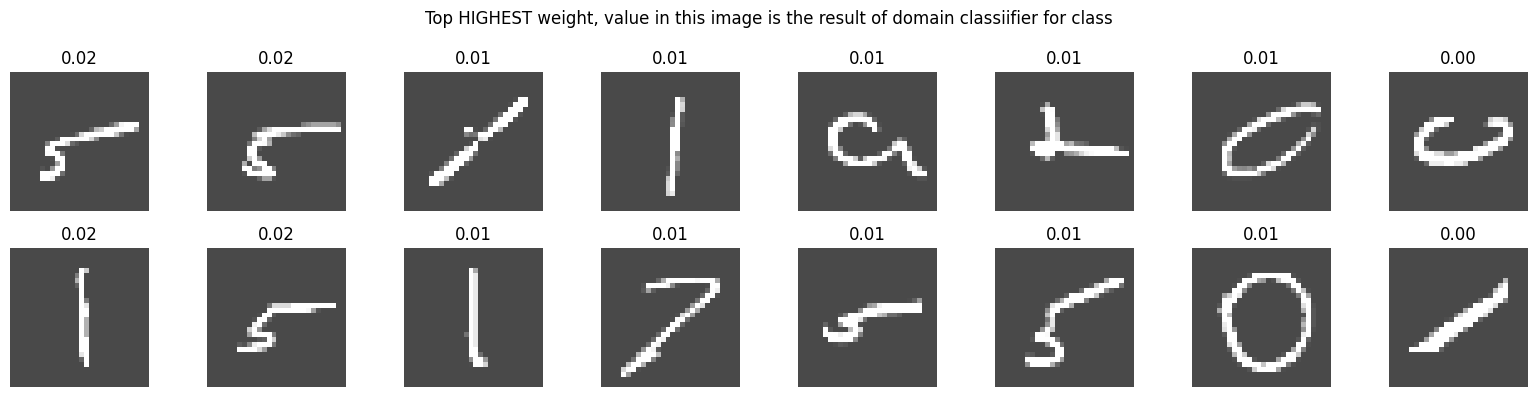

In [49]:
plot_top_images(combined_source_images, combined_domain_output, top_k=16, axis= 0)

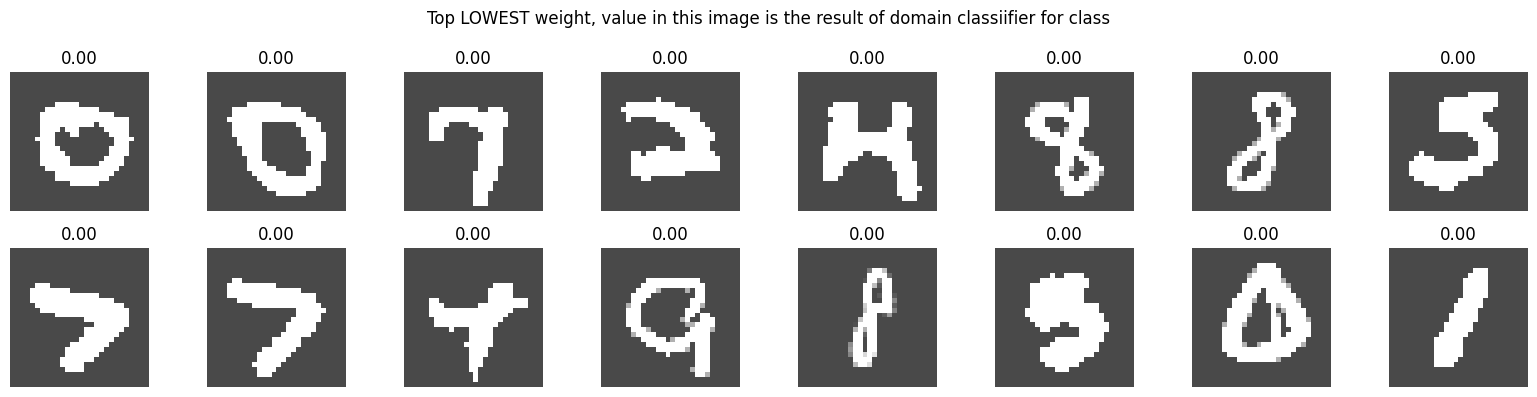

In [50]:
plot_top_images(combined_source_images, combined_domain_output, top_k=16, axis= 1)

 *As the images plotted, the images that have higher `reweights score` to the domain output are very similar to the TARGET domain (back and white)*

**Chart 1:**
Chart visualize the value of domain classifier probability output.

<ipython-input-51-f608f66c753b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_outputs = torch.tensor(domain_outputs).clone().detach()
<ipython-input-51-f608f66c753b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_outputs = torch.tensor(domain_outputs)


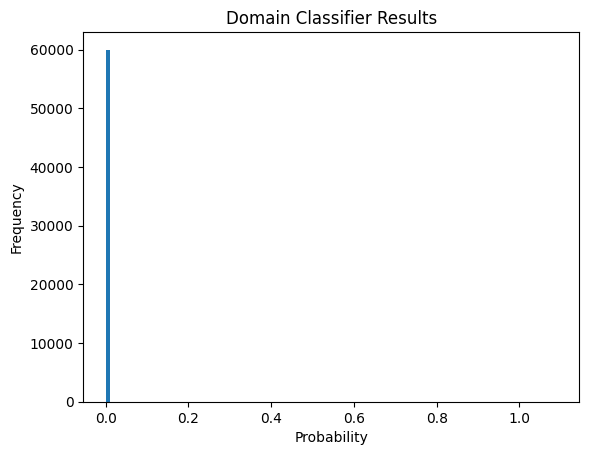

In [51]:
import matplotlib.pyplot as plt
import torch

def visualize_domain_classifier_results(domain_outputs):
    # Convert the list to a tensor
    domain_outputs = torch.tensor(domain_outputs).clone().detach()
    domain_outputs = torch.tensor(domain_outputs)

    # Move the tensor to CPU
    domain_outputs = domain_outputs.cpu()

    # Extract the probability values for the first class
    first_class_probs = domain_outputs[:, 0]

    # Convert the tensor to a NumPy array
    first_class_probs = first_class_probs.numpy()

    # Create the histogram with bins of 0.1
    bins = torch.arange(0, 1.1, 0.01)
    plt.hist(first_class_probs, bins=bins)

    # Set the chart labels and title
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Domain Classifier Results')

    # Show the chart
    plt.show()



visualize_domain_classifier_results(combined_domain_output)


-> Analysis: The probability around 0 are dominant which mean model perform very well on the domain classification task. Which also mean the samples that have high weight would be "small" (less than 1%)

- We then compute the reweight score of for output probability

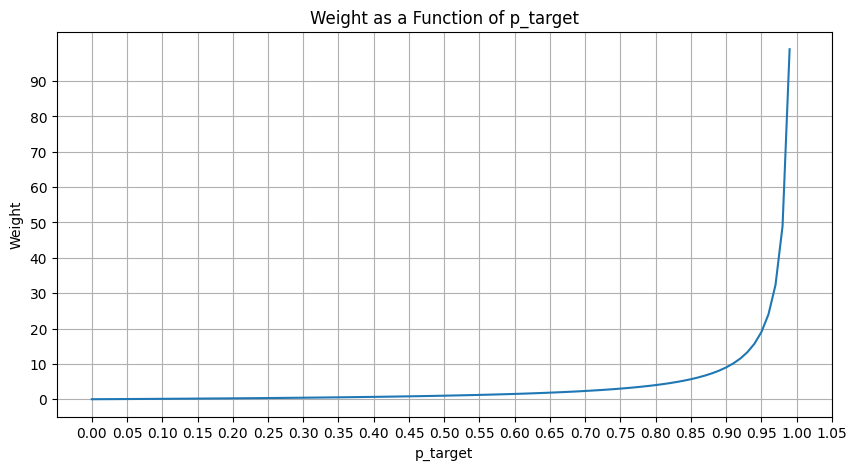

In [52]:
import matplotlib.pyplot as plt
import numpy as np

p_target = np.arange(0, 1, 0.01)

def cal_weight(p_target):

    return p_target / (1 - p_target + 1e-8)

# Apply the cal_weight function to p_target using np.vectorize
result = np.vectorize(cal_weight)(p_target)

# Increase the width of the chart
plt.figure(figsize=(10, 5))

# Plot the chart
plt.plot(p_target, result)
plt.xlabel('p_target')
plt.ylabel('Weight')
plt.title('Weight as a Function of p_target')

plt.xticks(np.arange(0, 1.1, 0.05))
plt.yticks(np.arange(0, 100, 10))

plt.grid(True)
plt.show()



`Weight` in the chart: mean `reweight score`

Conclusion: The scale of the reweight scores is large, which means that some samples are heavily reweighted, indicating their similarity to the TARGET domain. For example, a reweight score of 90 would result in the loss of that sample being multiplied by 90. On the other hand, some samples are reweighted with very small values, indicating their similarity to the SOURCE domain. This imbalance in reweight scores can have an impact on the model's training.

To address this issue and mitigate the imbalance, we propose using both `clipping`  and `square root transformations` in the loss function. Clipping can limit the range of the reweight scores, preventing extreme values from dominating the training process. Applying the square root transformation helps to reduce the disparity between large and small reweight scores, promoting a more balanced influence of different samples on the model's learning.


After apply  `square root transformations`, we have the scale of reweight as below

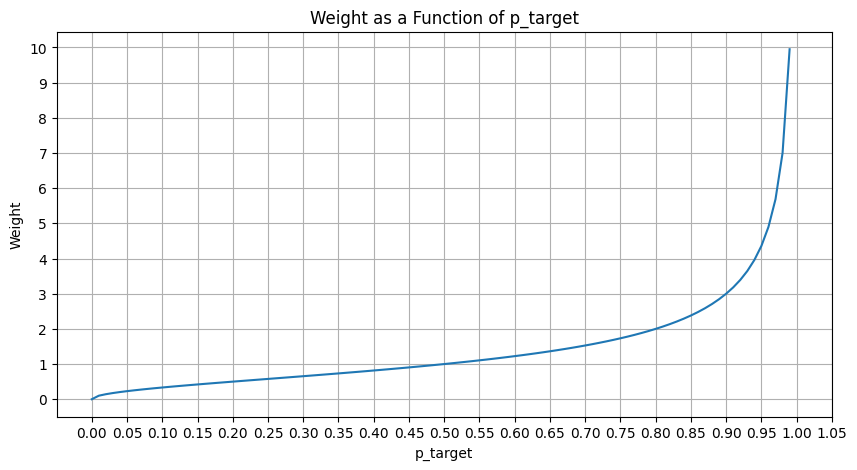

In [53]:
import matplotlib.pyplot as plt
import numpy as np

p_target = np.arange(0, 1, 0.01)

def cal_weight(p_target):

    return np.sqrt(p_target / (1 - p_target + 1e-8))

# Apply the cal_weight function to p_target using np.vectorize
result = np.vectorize(cal_weight)(p_target)

# Increase the width of the chart
plt.figure(figsize=(10, 5))

# Plot the chart
plt.plot(p_target, result)
plt.xlabel('p_target')
plt.ylabel('Weight')
plt.title('Weight as a Function of p_target')

plt.xticks(np.arange(0, 1.1, 0.05))
plt.yticks(np.arange(0, 11, 1))

plt.grid(True)
plt.show()



**Visualize the output probability of the Domain Classifier:**
As we see we have large amount of sample that have low weight and small amount amount of sample that have high weight.


<ipython-input-54-fc8b17cc3f34>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_outputs = torch.tensor(domain_outputs).clone().detach()
<ipython-input-54-fc8b17cc3f34>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_outputs = torch.tensor(domain_outputs)


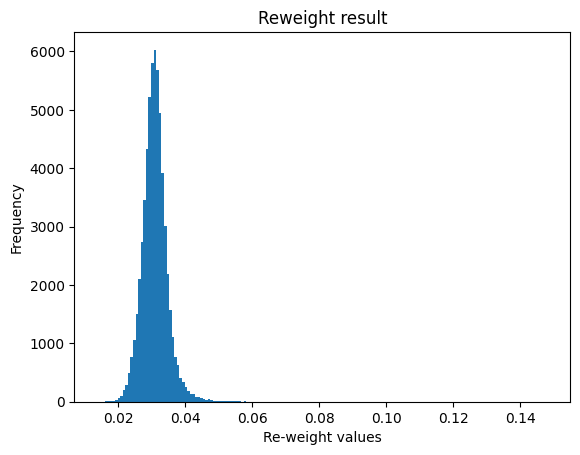

In [54]:

def visualize_domain_reweighting(domain_outputs):
    # Convert the list to a tensor
    domain_outputs = torch.tensor(domain_outputs).clone().detach()

    domain_outputs = torch.tensor(domain_outputs)

    # Move the tensor to CPU
    domain_outputs = domain_outputs.cpu()

    # Extract the probability values for the first class
    first_class_probs = domain_outputs[:, 0]

    # Convert the tensor to a NumPy array
    first_class_probs = first_class_probs.numpy()
    weight_factor = lambda x: np.sqrt(x / ((1 - x) + 1e-8))

    result = np.vectorize(weight_factor)(first_class_probs)
    # Create the histogram with bins of 0.1
    plt.hist(result, bins=175)

    # Set the chart labels and title
    plt.xlabel('Re-weight values')
    plt.ylabel('Frequency')
    plt.title('Reweight result')

    # Show the chart
    plt.show()
    return result


reweight_values = visualize_domain_reweighting(combined_domain_output)

## Loss Function
According to the analysis above, we redesign our Loss Function

In [55]:
class ReweightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(ReweightedCrossEntropyLoss, self).__init__()
        self.loss_function = nn.CrossEntropyLoss(reduction='none')

    def forward(self, input, label, domain_output, threshold, max_value):
        # Calculate the standard CrossEntropyLoss
        loss = self.loss_function(input, label)

        source_prob = domain_output[:, 1]
        target_prob = domain_output[:, 0]
        # square root transformation
        weights = torch.sqrt(target_prob / (source_prob + 1e-8))  # Add a small epsilon to avoid division by zero

        # Clip the importance weights
        weights = torch.where(weights < threshold, torch.tensor(threshold), weights)
        weights = torch.where(weights > max_value, torch.tensor(max_value), weights)

        weighted_loss = (weights * loss).mean()

        return weighted_loss


<ipython-input-59-447b6efa257f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(combined_source_images).clone().detach()


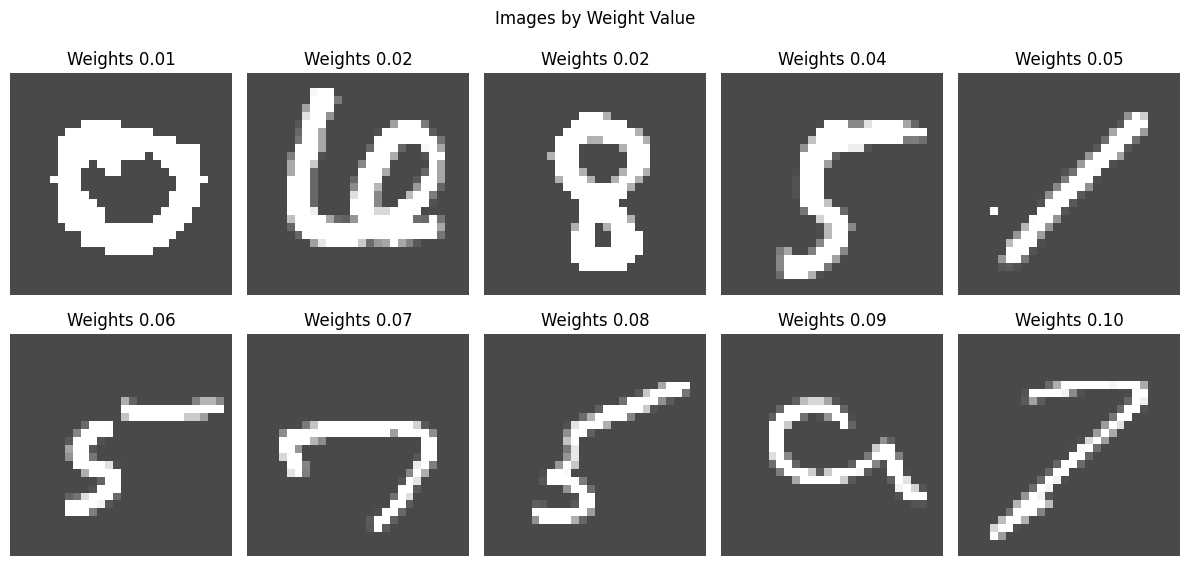

In [59]:
def plot_images_by_weight(images, weights, weight_values):
    fig, axs = plt.subplots(2, len(weight_values)//2, figsize=(12, 6))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, weight_value in enumerate(weight_values):
        # Find the indices where weights are larger than the target weight value
        if weight_value < 1:
            noise = np.random.uniform(0.001, 0.01, 1)[0]
        indices = np.where(weights > weight_value+noise)[0]

        if len(indices) > 0:
            # Get the minimum weight value among the selected indices
            min_weight_idx = np.argmin(weights[indices])
            idx = indices[min_weight_idx]
            image = images[idx]
            image = np.transpose(image, (1, 2, 0))
            image = image * 0.5 + 0.5  # Convert image tensor to numpy array

            row = i // (len(weight_values)//2)  # Determine the row index
            col = i % (len(weight_values)//2)  # Determine the column index

            axs[row, col].imshow(image)
            axs[row, col].set_title(f'Weights {weights[idx]:.2f}')

            axs[row, col].axis('off')
        else:
            print(f"No image found for weight value: {weight_value}")

    plt.suptitle('Images by Weight Value')
    plt.tight_layout()
    plt.show()

# Assuming images is a list or array of image tensors, and weights is a list or array of corresponding weight values
range_width = 0.01  # Adjust the range width as desired

images = torch.tensor(combined_source_images).clone().detach()
images = images.cpu()
chosen_values = [0, 0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
plot_images_by_weight(images, reweight_values, chosen_values)


- Very small amount of source data have the similar "domain" to the target data. we use clipping to not lossing informatin of the source dataset.

# Train the Label Classifier

In the code below, I ran the model 5 times and record the result on TARGET


In [60]:
thes = 3
max_value = 4


lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 5


output_accuracies = []
for run_num in range(5) :
    LOSS_LABEL = []
    ACC_LABEL = []

    # Model, Loss, and Optimizer
    label_classifier = LabelClassifier().to(device)
    loss_label = ReweightedCrossEntropyLoss()
    optimizer = optim.Adam(label_classifier.parameters(), lr=lr)

    # Training loop
    input_dataloader = combined_dataloader
    acc_result = []
    for epoch in range(n_epoch):
        correct = 0
        total_samples = 0
        data_iter = iter(input_dataloader)
        for i in range(len(input_dataloader)):
            len_dataloader = len(input_dataloader)
            data_source = next(data_iter)
            img, label, domain_clf_output = data_source
            batch_size = len(img)
            input_img = img.to(device)
            label = label.to(device)
            label_output = label_classifier(input_img)
            label_pred = torch.argmax(label_output, dim=1)
            correct += (label_pred == label).sum().item()
            total_samples += batch_size
            label_acc = 100.0 * correct / total_samples
            with torch.no_grad():
                detached_domain_output = domain_clf_output.detach()
            loss = loss_label(label_output, label, domain_clf_output, thes, max_value)
            ACC_LABEL.append(label_acc)
            LOSS_LABEL.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i % 200) == 0 and i != 0:
                print(f'epoch: {epoch+1}, [iter: {i:03d} / all {len_dataloader}], '
                    f'loss label: {loss.item():.4f}, '
                    f'| label acc (SOURCE): {label_acc:.4f}')


        # run on test set after each epochs to monitor result on test set (target set)
        domain_outputs = []
        source_train_images_list = []
        source_train_labels_list = []
        total_correct = 0
        total_samples = 0
        label_classifier.eval()
        for batch_data in target_dataloader:
            train_images, train_labels = batch_data
            batch_size = len(train_labels)
            input_images = train_images.to(device)
            class_label = train_labels.to(device)
            with torch.no_grad():
                pred_output = label_classifier(input_images)
                class_pred = torch.argmax(pred_output, dim=1)
                correct = (class_pred == class_label).sum().item()
                total = len(class_label)
                total_correct += correct
                total_samples += total
        accuracy = 100.0 * total_correct / total_samples
        print(f"Accuracy of label classifier (on TARGET) with reweight loss after epoch {epoch+1}: {accuracy:.4f}%")
        acc_result.append(accuracy)
    output_accuracies.append(accuracy)

    print("Run num: ", run_num, ', '.join([f'{i:.4f}' for i in acc_result]))
    print("------------------------------------------")
    print("\n")


print("-> Accuracies of 5 runs: ", ', '.join([f'{i:.2f}' for i in output_accuracies]))
_acc  = np.array(output_accuracies)
_avg = np.mean(_acc, axis=0)

print(f"-> Average accuracy of 5 runs: {_avg:.2f}")


epoch: 1, [iter: 200 / all 469], loss label: 0.4252, | label acc (SOURCE): 89.0897
epoch: 1, [iter: 400 / all 469], loss label: 0.3296, | label acc (SOURCE): 92.9278
Accuracy of label classifier (on TARGET) with reweight loss after epoch 1: 57.2475%
epoch: 2, [iter: 200 / all 469], loss label: 0.2549, | label acc (SOURCE): 98.0644
epoch: 2, [iter: 400 / all 469], loss label: 0.1959, | label acc (SOURCE): 98.1121
Accuracy of label classifier (on TARGET) with reweight loss after epoch 2: 58.2085%
epoch: 3, [iter: 200 / all 469], loss label: 0.0700, | label acc (SOURCE): 98.5541
epoch: 3, [iter: 400 / all 469], loss label: 0.0293, | label acc (SOURCE): 98.6050
Accuracy of label classifier (on TARGET) with reweight loss after epoch 3: 60.7254%
epoch: 4, [iter: 200 / all 469], loss label: 0.0758, | label acc (SOURCE): 98.9739
epoch: 4, [iter: 400 / all 469], loss label: 0.1392, | label acc (SOURCE): 98.9850
Accuracy of label classifier (on TARGET) with reweight loss after epoch 4: 57.7559%


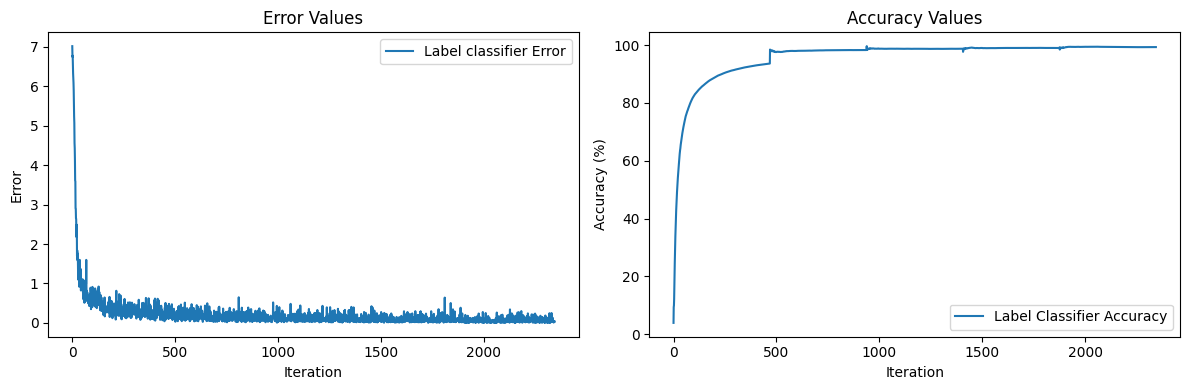

In [61]:
import matplotlib.pyplot as plt

LOSS_LABEL_list = [v.cpu().item() for v in LOSS_LABEL]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plotting error values
axes[0].plot(LOSS_LABEL_list, label='Label classifier Error')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Error')
axes[0].set_title('Error Values')
axes[0].legend()

# Plotting accuracy values
axes[1].plot(ACC_LABEL, label='Label Classifier Accuracy')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Values')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


# Comparision
Comparision with Classical Method: Use only Label Classifier, we use CrossEntropyLoss in this case




In [62]:
import torch.optim as optim

# Hyperparameters
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 5

output_accuracies = []
for run_num in range(5):
    output = []


    # Model, Loss, and Optimizer
    traditional_label_classifier = LabelClassifier().to(device)
    loss_label_no_dc = nn.CrossEntropyLoss()
    optimizer = optim.Adam(traditional_label_classifier.parameters(), lr=lr)

    # Training loop
    CLASSICAL_LOSS_LABEL = []
    CLASSICAL_ACC_LABEL = []

    for epoch in range(n_epoch):
        correct = 0
        total_samples = 0
        input_dataloader = combined_dataloader
        data_iter = iter(input_dataloader)

        for i in range(len(input_dataloader)):
            len_dataloader = len(input_dataloader)

            data_source = next(data_iter)
            img, label, _= data_source
            batch_size = len(img)
            input_img = img.to(device)
            label = label.to(device)

            label_output = traditional_label_classifier(input_img)
            label_pred = torch.argmax(label_output, dim=1)

            correct += (label_pred == label).sum().item()
            total_samples += len(label)

            label_acc = 100.0 * correct / total_samples
            loss = loss_label_no_dc(label_output, label)

            CLASSICAL_ACC_LABEL.append(label_acc)
            CLASSICAL_LOSS_LABEL.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i % 200) == 0 and i != 0:
                print(f'epoch: {epoch+1}, [iter: {i:03d} / all {len_dataloader}], '
                      f'loss label: {loss.item():.4f}, '
                      f'| label acc (SOURCE): {label_acc:.4f}')

        # Evaluation on target dataset after each epoch
        domain_outputs = []
        source_train_images_list = []
        source_train_labels_list = []

        total_correct = 0
        total_samples = 0

        traditional_label_classifier.eval()

        for batch_data in target_dataloader:
            train_images, train_labels = batch_data
            batch_size = len(train_labels)

            input_images = train_images.to(device)
            class_label = train_labels.to(device)

            with torch.no_grad():
                pred_output = traditional_label_classifier(input_images)
                class_pred = torch.argmax(pred_output, dim=1)

                correct = (class_pred == class_label).sum().item()
                total = len(class_label)

                total_correct += correct
                total_samples += total

        accuracy = 100.0 * total_correct / total_samples
        print(f"- Accuracy of label classifier (predict on TARGET) after epoch {epoch+1}: {accuracy:.2f}%")
        output.append(accuracy)

    output_accuracies.append(accuracy)

    print('Run number', run_num, '|', ', '.join([f'{i:.2f}' for i in output]))
    print("\n")

print("\n")
print("-> Accuracies of 5 runs: ", ', '.join([f'{i:.2f}' for i in output_accuracies]))
_acc  = np.array(output_accuracies)
_avg = np.mean(_acc, axis=0)

print(f"-> Average accuracy of 5 runs: {_avg:.2f}")


epoch: 1, [iter: 200 / all 469], loss label: 0.0740, | label acc (SOURCE): 88.5494
epoch: 1, [iter: 400 / all 469], loss label: 0.1402, | label acc (SOURCE): 92.6960
- Accuracy of label classifier (predict on TARGET) after epoch 1: 37.66%
epoch: 2, [iter: 200 / all 469], loss label: 0.0762, | label acc (SOURCE): 97.9711
epoch: 2, [iter: 400 / all 469], loss label: 0.0306, | label acc (SOURCE): 98.1784
- Accuracy of label classifier (predict on TARGET) after epoch 2: 43.06%
epoch: 3, [iter: 200 / all 469], loss label: 0.0254, | label acc (SOURCE): 98.6046
epoch: 3, [iter: 400 / all 469], loss label: 0.0252, | label acc (SOURCE): 98.6382
- Accuracy of label classifier (predict on TARGET) after epoch 3: 54.70%
epoch: 4, [iter: 200 / all 469], loss label: 0.0127, | label acc (SOURCE): 98.8923
epoch: 4, [iter: 400 / all 469], loss label: 0.0899, | label acc (SOURCE): 98.9830
- Accuracy of label classifier (predict on TARGET) after epoch 4: 52.53%
epoch: 5, [iter: 200 / all 469], loss label:

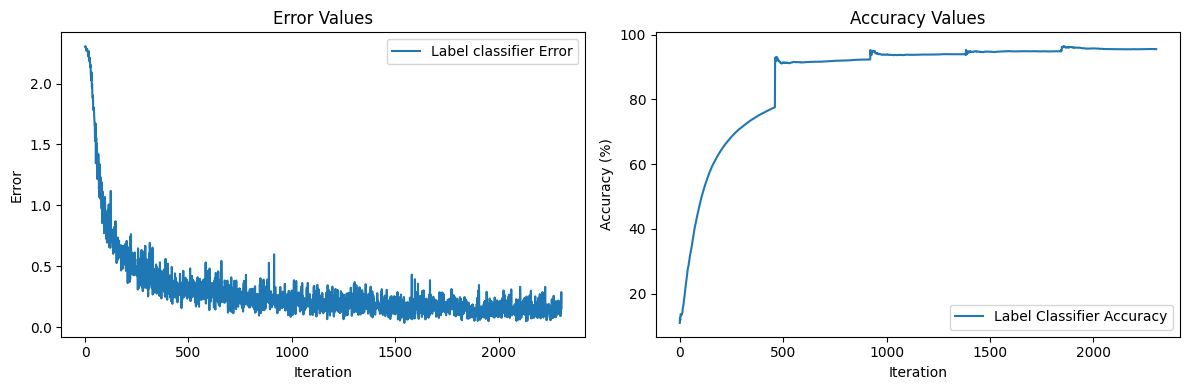

In [ ]:
import matplotlib.pyplot as plt


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plotting error values
axes[0].plot(CLASSICAL_LOSS_LABEL, label='Label classifier Error')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Error')
axes[0].set_title('Error Values')
axes[0].legend()

# Plotting accuracy values
axes[1].plot(CLASSICAL_ACC_LABEL, label='Label Classifier Accuracy')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Values')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
